### Import

In [1]:
from predict_ensemble_and_evaluate_paper import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate_paper import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sympy import re

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "sonar":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split
        import re
  
        # fetch dataset 
        sonar = fetch_ucirepo(id=151) 
        
        # data (as pandas dataframes) 
        X_df = sonar.data.features 
        y_df = sonar.data.targets 

        X = X_df.to_numpy()
        y = y_df.to_numpy()

       
        # . Encode the target variable
        y = LabelEncoder().fit_transform(y)

        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=0.7,  # 70% for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test

        print(f"X_train type: {type(X_train)}, ndim: {X_train.ndim}, shape: {X_train.shape}")
        print(f"y_train type: {type(y_train)}, ndim: {y_train.ndim}, shape: {y_train.shape}")
        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")


    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Sonar: NN

In [7]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("sonar")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





Training data shape: (145, 60), (145,)
Test data shape: (63, 60), (63,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 60)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 1)
Shape of training data: (145, 61)
Shape of test data: (63, 61)

Data successfully processed and concatenated.
Shape of final training data: (145, 61)


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Neural Network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

In [9]:
class MLP(nn.Module):
    def __init__(self, input_features=14, hidden_units=16, num_classes=1):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units//2),
            nn.ReLU(),
            nn.Linear(hidden_units//2, num_classes),
        )

    def forward(self, x):
        return self.network(x)
    
# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=14, hidden_units=16, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = MLP(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification
        self.strict_loading = False 

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [10]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = train_data.shape[1] - 1
hidden_units = 8

### Regular training

In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='MLP-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s, v_num=5]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v3.ckpt



Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v3.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v3.ckpt ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6253
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6932323575019836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on Test Set ---


In [12]:

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
tn, fp, fn, tp = confusion_matrix(true_labels, final_predictions).ravel()

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)
#print the misclassification risk of the original model
prior_proba = np.mean(test_data[:, -1])
tpr_orig = tp/(tp + fn) if(tp + fn) > 0 else 0.0
fpr_orig = fp/(fp + tn) if(fp + tn) > 0 else 0.0
risk = (prior_proba * (1 - tpr_orig)) + ((1 - prior_proba) * fpr_orig)
f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
misclassification_risk_orig = {
    "risk": risk,
    "tpr": tpr_orig,
    "fpr": fpr_orig,
    "threshold": prior_proba,
    "f1": f1
}
print(f"Misclassification Risk original model: {misclassification_risk_orig}")


--- Confusion Matrix ---

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        34
     Class 1       0.46      1.00      0.63        29

    accuracy                           0.46        63
   macro avg       0.23      0.50      0.32        63
weighted avg       0.21      0.46      0.29        63

Misclassification Risk original model: {'risk': np.float64(0.5396825396825398), 'tpr': np.float64(1.0), 'fpr': np.float64(1.0), 'threshold': np.float64(0.4603174603174603), 'f1': np.float64(0.6304347826086957)}


## Weighted ROC curve

In [13]:
NUM_CLASSIFIERS = 100
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    # 1. Instantiate the LightningModule
    model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)


--- Starting Fold 1/4 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 39.81it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 34.75it/s, v_num=20]


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v20.ckpt


--- Fold 1 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5565
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6916488409042358
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.55it/s, v_num=4]
--- Fold 1 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5676
AUC: 0.5640
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6922706365585327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.36it/s, v_num=4]
--- Fold 1 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.5625
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6928717494010925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.61it/s, v_num=4]
--- Fold 1 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.5908
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6933815479278564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.52it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.11it/s, v_num=4]
--- Fold 1 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6131
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6938319802284241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.69it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.00it/s, v_num=4]
--- Fold 1 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6280
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6944485306739807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.69it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.61it/s, v_num=4]
--- Fold 1 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6951484680175781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.72it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.63it/s, v_num=4]
--- Fold 1 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6682
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6958948969841003
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.44it/s, v_num=4]
--- Fold 1 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6845
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966816782951355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.79it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.35it/s, v_num=4]
--- Fold 1 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7083
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.05it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6974791884422302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.74it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.56it/s, v_num=4]
--- Fold 1 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7143
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983749866485596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.40it/s, v_num=4]
--- Fold 1 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7217
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6992834806442261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.36it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.08it/s, v_num=4]
--- Fold 1 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7411
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003259062767029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 96.91it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.57it/s, v_num=4]
--- Fold 1 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7530
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013946175575256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.57it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.34it/s, v_num=4]
--- Fold 1 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7025746703147888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, v_num=4]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7664
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.60it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7038272023200989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.96it/s, v_num=4]
--- Fold 1 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7768
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051877379417419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.77it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.07it/s, v_num=4]
--- Fold 1 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066209316253662
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.33it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.51it/s, v_num=4]
--- Fold 1 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 236.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7798
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081447243690491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.07it/s, v_num=4]
--- Fold 1 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 20 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v20.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7812
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7097602486610413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.90it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v20.ckpt


--- Fold 1 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7902
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7114659547805786
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.72it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.96it/s, v_num=4]
--- Fold 1 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7872
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7132733464241028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.67it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s, v_num=4]
--- Fold 1 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7917
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715154767036438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.86it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.63it/s, v_num=4]
--- Fold 1 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7946
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7172558903694153
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 95.81it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.28it/s, v_num=4]
--- Fold 1 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7917
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7194145917892456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.24it/s, v_num=4]
--- Fold 1 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8021
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.90it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7216585874557495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.55it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.21it/s, v_num=4]
--- Fold 1 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8051
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7240068912506104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.64it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.65it/s, v_num=4]
--- Fold 1 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8065
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7263748645782471
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.73it/s, v_num=4]
--- Fold 1 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8051
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.92it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7289096117019653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.76it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.33it/s, v_num=4]
--- Fold 1 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 257.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8095
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.53it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7316676378250122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.77it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.77it/s, v_num=4]
--- Fold 1 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8095
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7343088984489441
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.82it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.51it/s, v_num=4]
--- Fold 1 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8214
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.37it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7372152805328369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v20.ckpt


--- Fold 1 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8199
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7405093312263489
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 75.91it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.94it/s, v_num=4]
--- Fold 1 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8214
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7435680031776428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.20it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.81it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v20.ckpt


--- Fold 1 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8259
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468677163124084
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.67it/s, v_num=4]
--- Fold 1 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 260.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8259
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7500609159469604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 97.33it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.30it/s, v_num=4]
--- Fold 1 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8274
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7535523176193237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.52it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.68it/s, v_num=4]
--- Fold 1 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.58it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7566677927970886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.14it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.03it/s, v_num=4]
--- Fold 1 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7596001625061035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.09it/s, v_num=4]
--- Fold 1 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8408
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.98it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.762614369392395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.19it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.05it/s, v_num=4]
--- Fold 1 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8423
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7611626386642456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.97it/s, v_num=4]
--- Fold 1 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8423
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7624883055686951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.17it/s, v_num=4]
--- Fold 1 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8542
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.73it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7604716420173645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.48it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.54it/s, v_num=4]
--- Fold 1 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8571
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.13it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7580059766769409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.95it/s, v_num=4]
--- Fold 1 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8661
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.99it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7554224729537964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 75.87it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.50it/s, v_num=4]
--- Fold 1 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 255.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8735
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.28it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7522958517074585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.54it/s, v_num=4]
--- Fold 1 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 47 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v20.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7488970160484314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.95it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.70it/s, v_num=4]
--- Fold 1 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8765
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7456023097038269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.50it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.16it/s, v_num=4]
--- Fold 1 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7420371174812317
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.69it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.57it/s, v_num=4]
--- Fold 1 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v20.ckpt



--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8824
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7404326796531677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.32it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.53it/s, v_num=4]
--- Fold 1 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7369605302810669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.23it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s, v_num=4]
--- Fold 1 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 247.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8854
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.733857274055481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.04it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.23it/s, v_num=4]
--- Fold 1 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8839
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7305572032928467
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.39it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.50it/s, v_num=4]
--- Fold 1 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 54 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v4.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8824
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.47it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7272166609764099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.13it/s, v_num=4]
--- Fold 1 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8750
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.81it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7241156101226807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 55.10it/s, v_num=4]
--- Fold 1 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212644219398499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.24it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s, v_num=4]
--- Fold 1 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8750
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7183789610862732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.51it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.02it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8735
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7157464027404785
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.72it/s, v_num=4]
--- Fold 1 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8646
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7132672667503357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.15it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8616
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7109809517860413
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.22it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.77it/s, v_num=4]
--- Fold 1 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8557
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7092581987380981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.64it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.37it/s, v_num=4]
--- Fold 1 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8452
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7069523930549622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.60it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.39it/s, v_num=4]
--- Fold 1 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8318
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7046432495117188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.73it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s, v_num=4]
--- Fold 1 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8080
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.17it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7024055123329163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.86it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.98it/s, v_num=4]
--- Fold 1 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7902
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.90it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7002220153808594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.38it/s, v_num=4]
--- Fold 1 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7738
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981454491615295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.78it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.89it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7649
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962647438049316
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.05it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.69it/s, v_num=4]
--- Fold 1 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7530
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6945335268974304
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.74it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.77it/s, v_num=4]
--- Fold 1 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.78it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6929253339767456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.41it/s, v_num=4]
--- Fold 1 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4865
AUC: 0.7143
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.98it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914956569671631
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s, v_num=4]
--- Fold 1 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.6935
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.13it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6902327537536621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.36it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.25it/s, v_num=4]
--- Fold 1 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6757
AUC: 0.6682
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6891087889671326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s, v_num=4]
--- Fold 1 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5135
AUC: 0.6443
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.77it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881715059280396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.13it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.42it/s, v_num=4]
--- Fold 1 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5405
AUC: 0.6250
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873897910118103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.57it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s, v_num=4]
--- Fold 1 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5405
AUC: 0.6071
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867791414260864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.42it/s, v_num=4]
--- Fold 1 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 261.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5685
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863494515419006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.23it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.68it/s, v_num=4]
--- Fold 1 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 77 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v4.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5506
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860853433609009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.42it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.64it/s, v_num=4]
--- Fold 1 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5312
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859346628189087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.91it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.35it/s, v_num=4]
--- Fold 1 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.82it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859928369522095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.21it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.84it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4911
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.93it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686232328414917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.27it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.76it/s, v_num=4]
--- Fold 1 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4702
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866469383239746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s, v_num=4]
--- Fold 1 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4494
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.687216579914093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.78it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.90it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4286
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.09it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881436705589294
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.42it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.16it/s, v_num=4]
--- Fold 1 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4137
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895170211791992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.97it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.44it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3914
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912352442741394
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.80it/s, v_num=4]
--- Fold 1 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3705
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693061351776123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.59it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.35it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3348
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6953023076057434
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.24it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.96it/s, v_num=4]
--- Fold 1 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4054
AUC: 0.3006
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6976563930511475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.79it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.53it/s, v_num=4]
--- Fold 1 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4054
AUC: 0.2842
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6989118456840515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.98it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.35it/s, v_num=4]
--- Fold 1 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.2708
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7002186179161072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.30it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.91it/s, v_num=4]
--- Fold 1 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3784
AUC: 0.2619
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7017114162445068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.60it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.13it/s, v_num=4]
--- Fold 1 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.35it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.59it/s, v_num=4]
--- Fold 1 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.14it/s, v_num=4]
--- Fold 1 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.38it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.64it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s, v_num=4]
--- Fold 1 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 96.24it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.25it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v4.ckpt


--- Fold 1 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 1 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.85it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032910585403442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules i

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.18it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.89it/s, v_num=4]
--- Fold 1 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 236.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.50it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.71it/s, v_num=4]
--- Fold 1 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032910585403442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s, v_num=4]
--- Fold 1 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.19it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 96.55it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 75.65it/s, v_num=4]
--- Fold 1 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v4.ckpt



--- Testing model after Fold 1 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.03it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)


--- Starting Fold 2/4 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.94it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.02it/s, v_num=20]
--- Fold 2 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5552
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.91it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7578020095825195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.06it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.57it/s, v_num=4]
--- Fold 2 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5351
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.753487229347229
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.23it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.91it/s, v_num=4]
--- Fold 2 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5502
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7496660947799683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.23it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.56it/s, v_num=4]
--- Fold 2 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5886
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.20it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7463839054107666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s, v_num=4]
--- Fold 2 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6020
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7432428002357483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.12it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 55.57it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v20.ckpt


--- Fold 2 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6070
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7401683330535889
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.22it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.66it/s, v_num=4]
--- Fold 2 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6104
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.736877977848053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.26it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.04it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v20.ckpt


--- Fold 2 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6171
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.733670711517334
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.59it/s, v_num=4]
--- Fold 2 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6137
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.81it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7303751111030579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.22it/s, v_num=4]
--- Fold 2 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.53it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7270854115486145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.92it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s, v_num=4]
--- Fold 2 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.16it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7237390279769897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.57it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s, v_num=4]
--- Fold 2 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203586101531982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.72it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.17it/s, v_num=4]
--- Fold 2 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v20.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v20.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v20.ckpt



--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7168800830841064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.56it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.46it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6154
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7134663462638855
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.27it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.63it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7100639939308167
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.80it/s, v_num=4]
--- Fold 2 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066970467567444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.28it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s, v_num=4]
--- Fold 2 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.38it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032997608184814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.07it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.15it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6304
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.60it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6999236345291138
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.24it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.6304
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6964181661605835
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.65it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.73it/s, v_num=4]
--- Fold 2 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.6355
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931223273277283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.38it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.76it/s, v_num=4]
--- Fold 2 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6355
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.64it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6897875070571899
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.33it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.82it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.6338
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.48it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686589777469635
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.93it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.68it/s, v_num=4]
--- Fold 2 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 257.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6388
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833253502845764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.24it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.27it/s, v_num=4]
--- Fold 2 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6111
AUC: 0.6388
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.58it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801134943962097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.78it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s, v_num=4]
--- Fold 2 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6338
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676989734172821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s, v_num=4]
--- Fold 2 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 26 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v19.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6355
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6739561557769775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.83it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.85it/s, v_num=4]
--- Fold 2 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6710140705108643
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.80it/s, v_num=4]
--- Fold 2 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6681607961654663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.35it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s, v_num=4]
--- Fold 2 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665456235408783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.72it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s, v_num=4]
--- Fold 2 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6628658771514893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.78it/s, v_num=4]
--- Fold 2 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 247.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6388
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6602019667625427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.12it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.01it/s, v_num=4]
--- Fold 2 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6580091118812561
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.11it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.15it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6556863784790039
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.47it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.39it/s, v_num=4]
--- Fold 2 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.28it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6537532806396484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.46it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.24it/s, v_num=4]
--- Fold 2 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6519436836242676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.29it/s, v_num=4]
--- Fold 2 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6288
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.17it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.650323212146759
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.24it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.61it/s, v_num=4]
--- Fold 2 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6254
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.27it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6490423083305359
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.11it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.72it/s, v_num=4]
--- Fold 2 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6288
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6476187109947205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.12it/s, v_num=4]
--- Fold 2 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.98it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6468945741653442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.11it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.86it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6460323929786682
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.69it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.51it/s, v_num=4]
--- Fold 2 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6456652283668518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.51it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6450989842414856
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.27it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.86it/s, v_num=4]
--- Fold 2 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.09it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.645611584186554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.93it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.17it/s, v_num=4]
--- Fold 2 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6355
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6461611390113831
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.86it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.63it/s, v_num=4]
--- Fold 2 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6405
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6470162868499756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.26it/s, v_num=4]
--- Fold 2 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6421
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.81it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6483221054077148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval 

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.71it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.69it/s, v_num=4]
--- Fold 2 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6505
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.09it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6498936414718628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.74it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v19.ckpt


--- Fold 2 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6498587131500244
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.97it/s, v_num=4]
--- Fold 2 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6515209674835205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.06it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.40it/s, v_num=4]
--- Fold 2 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v19.ckpt



--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.17it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6536831259727478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.98it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.55it/s, v_num=4]
--- Fold 2 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 255.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.73it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6547618508338928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.80it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.65it/s, v_num=4]
--- Fold 2 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.27it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6568480730056763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.97it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.77it/s, v_num=4]
--- Fold 2 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6505
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.51it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6588074564933777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.77it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.72it/s, v_num=4]
--- Fold 2 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6522
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.15it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.66158127784729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.71it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.22it/s, v_num=4]
--- Fold 2 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6572
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.68it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6643902659416199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.32it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.39it/s, v_num=4]
--- Fold 2 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 257.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.28it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6670925617218018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.06it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.10it/s, v_num=4]
--- Fold 2 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.08it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.670524001121521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s, v_num=4]
--- Fold 2 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6522
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6743164658546448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.30it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.81it/s, v_num=4]
--- Fold 2 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6522
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.67it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6771798729896545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.19it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.94it/s, v_num=4]
--- Fold 2 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680553138256073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v4.ckpt


--- Fold 2 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 2 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.51it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684956431388855
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.55it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s, v_num=4]
--- Fold 2 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6538
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.47it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895883083343506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 95.57it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.40it/s, v_num=4]
--- Fold 2 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.6555
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941244602203369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s, v_num=4]
--- Fold 2 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.6488
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6982969045639038
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.05it/s, v_num=4]
--- Fold 2 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6488
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.702688992023468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.89it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.87it/s, v_num=4]
--- Fold 2 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7063611149787903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.41it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.35it/s, v_num=4]
--- Fold 2 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7118613123893738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.21it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.84it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v4.ckpt


--- Fold 2 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 2 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7171821594238281
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.82it/s, v_num=4]
--- Fold 2 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6355
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7225325703620911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.91it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v4.ckpt


--- Fold 2 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 2 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6254
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7276525497436523
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.12it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s, v_num=4]
--- Fold 2 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6120
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7333219647407532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.92it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.65it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v4.ckpt


--- Fold 2 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 2 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5920
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7392271161079407
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.33it/s, v_num=4]
--- Fold 2 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5803
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7443571090698242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.45it/s, v_num=4]
--- Fold 2 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5702
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7501963376998901
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.37it/s, v_num=4]
--- Fold 2 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5602
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.98it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7556070685386658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s, v_num=4]
--- Fold 2 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5452
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7608063817024231
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.77it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.38it/s, v_num=4]
--- Fold 2 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5452
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7663908004760742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.35it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.84it/s, v_num=4]
--- Fold 2 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.5468
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.10it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7720918655395508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s, v_num=4]
--- Fold 2 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.5502
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.14it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7783010005950928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.05it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.53it/s, v_num=4]
--- Fold 2 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.5518
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7852666974067688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.56it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s, v_num=4]
--- Fold 2 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.5452
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7921242713928223
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.89it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.12it/s, v_num=4]
--- Fold 2 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.5234
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.44it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8003932237625122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.11it/s, v_num=4]
--- Fold 2 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.4950
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8086803555488586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.51it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.46it/s, v_num=4]
--- Fold 2 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.5084
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8158314228057861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.14it/s, v_num=4]
--- Fold 2 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5151
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8228578567504883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.34it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.06it/s, v_num=4]
--- Fold 2 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5100
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.76it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8295314908027649
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.18it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.29it/s, v_num=4]
--- Fold 2 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5033
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8362210392951965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.20it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.47it/s, v_num=4]
--- Fold 2 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4883
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8395141959190369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.45it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s, v_num=4]
--- Fold 2 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4833
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8426292538642883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.69it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.06it/s, v_num=4]
--- Fold 2 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 233.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4749
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.87it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8459306955337524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.79it/s, v_num=4]
--- Fold 2 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4716
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.46it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8491118550300598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.15it/s, v_num=4]
--- Fold 2 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4632
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.93it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8522418141365051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 97.92it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.15it/s, v_num=4]
--- Fold 2 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4699
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.855370819568634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.30it/s, v_num=4]
--- Fold 2 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.31it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.85it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.23it/s, v_num=4]
--- Fold 2 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8585093021392822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.79it/s, v_num=4]
--- Fold 2 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.75it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.93it/s, v_num=4]
--- Fold 2 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.95it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 75.12it/s, v_num=4]
--- Fold 2 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.03it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.89it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v4.ckpt


--- Fold 2 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 2 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.90it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8585093021392822
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.63it/s, v_num=4]
--- Fold 2 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v4.ckpt



--- Testing model after Fold 2 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Starting Fold 3/4 ---

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.21it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s, v_num=19]
--- Fold 3 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5127
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879286170005798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s, v_num=4]
--- Fold 3 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.4952
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6891428828239441
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.70it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.19it/s, v_num=4]
--- Fold 3 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5143
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.15it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903827786445618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.29it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.57it/s, v_num=4]
--- Fold 3 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5302
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6917272210121155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s, v_num=4]
--- Fold 3 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5444
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931055188179016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.57it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5508
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6946380138397217
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.66it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.33it/s, v_num=4]
--- Fold 3 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5762
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962762475013733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.67it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.11it/s, v_num=4]
--- Fold 3 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5778
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.93it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981621980667114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.03it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.86it/s, v_num=4]
--- Fold 3 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5698
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003009915351868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.92it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s, v_num=4]
--- Fold 3 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7026192545890808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.21it/s, v_num=4]
--- Fold 3 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051182389259338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.21it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.99it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5651
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.04it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7077916264533997
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules i

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.66it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.82it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106760144233704
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.76it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.36it/s, v_num=4]
--- Fold 3 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7137266993522644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.87it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.32it/s, v_num=4]
--- Fold 3 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7168776988983154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.70it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.37it/s, v_num=4]
--- Fold 3 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203562259674072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.34it/s, v_num=4]
--- Fold 3 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7238615155220032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.48it/s, v_num=4]
--- Fold 3 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7277104258537292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.34it/s, v_num=4]
--- Fold 3 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.93it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7317388653755188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.86it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.19it/s, v_num=4]
--- Fold 3 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.735838770866394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.36it/s, v_num=4]
--- Fold 3 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7397524118423462
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.25it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.96it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7435963749885559
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.85it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.45it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5778
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7473653554916382
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.59it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5841
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7502914071083069
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s, v_num=4]
--- Fold 3 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7530317306518555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.83it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.03it/s, v_num=4]
--- Fold 3 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.90it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7514317631721497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.75it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.67it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6079
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.19it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7488992810249329
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.74it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.92it/s, v_num=4]
--- Fold 3 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6063
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.67it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.745743989944458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.36it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.10it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6095
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7424561381340027
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.30it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s, v_num=4]
--- Fold 3 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6206
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7388253808021545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.28it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.67it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6270
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7351951599121094
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.22it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6286
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.88it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7317620515823364
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.58it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.21it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6302
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.64it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7279990315437317
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.94it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.37it/s, v_num=4]
--- Fold 3 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6286
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.728476345539093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.69it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6365
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7244555950164795
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.65it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.81it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v19.ckpt


--- Fold 3 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6492
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.93it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7208863496780396
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.15it/s, v_num=4]
--- Fold 3 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6540
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.93it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.717717707157135
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.70it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.05it/s, v_num=4]
--- Fold 3 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 258.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6714
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7147008180618286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.13it/s, v_num=4]
--- Fold 3 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6762
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7113221883773804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.43it/s, v_num=4]
--- Fold 3 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6857
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081186771392822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.20it/s, v_num=4]
--- Fold 3 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6889
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7050073742866516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s, v_num=4]
--- Fold 3 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6921
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.99it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7021110653877258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.86it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s, v_num=4]
--- Fold 3 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6952
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.699272632598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s, v_num=4]
--- Fold 3 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7032
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966660618782043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.80it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.33it/s, v_num=4]
--- Fold 3 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7111
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6943562626838684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.96it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s, v_num=4]
--- Fold 3 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921496987342834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.24it/s, v_num=4]
--- Fold 3 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.13it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6900404095649719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.78it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s, v_num=4]
--- Fold 3 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7365
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879367232322693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.31it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.72it/s, v_num=4]
--- Fold 3 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7476
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860965490341187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.46it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.69it/s, v_num=4]
--- Fold 3 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v19.ckpt



--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7540
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.60it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843281984329224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.46it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.63it/s, v_num=4]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Fold 3 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7508
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.05it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6826349496841431
───────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.68it/s, v_num=4]
--- Fold 3 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7619
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.52it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6809769868850708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.19it/s, v_num=4]
--- Fold 3 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7476
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.67it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795796155929565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.89it/s, v_num=4]
--- Fold 3 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7619
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6783291697502136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.93it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.42it/s, v_num=4]
--- Fold 3 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7571
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.37it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6773121356964111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.44it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.50it/s, v_num=4]
--- Fold 3 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7651
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765695810317993
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.01it/s, v_num=4]
--- Fold 3 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7667
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761555075645447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.26it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 53.92it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7571
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757352948188782
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.16it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.69it/s, v_num=4]
--- Fold 3 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 254.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7397
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6753932237625122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.60it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.32it/s, v_num=4]
--- Fold 3 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7524
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6748677492141724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.26it/s, v_num=4]
--- Fold 3 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7556
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.49it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6744204759597778
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.59it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.90it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7524
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6740398406982422
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.78it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.40it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7397
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673608124256134
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.55it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7317
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.52it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6732699871063232
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.11it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.86it/s, v_num=4]
--- Fold 3 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7492
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6727277040481567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.97it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.82it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7349
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724312901496887
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 78.13it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.63it/s, v_num=4]
--- Fold 3 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.672469973564148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.38it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7111
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726592183113098
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.28it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.53it/s, v_num=4]
--- Fold 3 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7206
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.28it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6722114086151123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.79it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.55it/s, v_num=4]
--- Fold 3 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7048
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724805235862732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 52.07it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7254
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.92it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6721184849739075
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.59it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.01it/s, v_num=4]
--- Fold 3 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7048
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6723434925079346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.77it/s, v_num=4]
--- Fold 3 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6921
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.82it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6728832721710205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.00it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.51it/s, v_num=4]
--- Fold 3 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726955771446228
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.51it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.49it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673028826713562
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.85it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6732764840126038
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.02it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.18it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.08it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6733496189117432
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.10it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.29it/s, v_num=4]
--- Fold 3 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6731558442115784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.32it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6825
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.89it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6736801862716675
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.94it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.52it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6746
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673687756061554
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.38it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.95it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6635
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.17it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6738870143890381
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.92it/s, v_num=4]
--- Fold 3 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6762
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6737626194953918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.92it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.78it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6778
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6740387678146362
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.95it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.01it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745935678482056
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.63it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.63it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6750023365020752
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.69it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6556
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752948760986328
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.64it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.03it/s, v_num=4]
--- Fold 3 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6571
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6749466061592102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.58it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.50it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.22it/s, v_num=4]
--- Fold 3 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.68it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.43it/s, v_num=4]
--- Fold 3 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.81it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.75it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.57it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 97.02it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 76.39it/s, v_num=4]
--- Fold 3 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.78it/s, v_num=4]
--- Fold 3 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.20it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.29it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 95.78it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 75.22it/s, v_num=4]
--- Fold 3 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.89it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.63it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.73it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.10it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.03it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.82it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.99it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v4.ckpt


--- Fold 3 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 3 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.65it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.19it/s, v_num=4]
--- Fold 3 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.07it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.13it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.53it/s, v_num=4]
--- Fold 3 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v4.ckpt



--- Testing model after Fold 3 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.92it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Fold 4/4 ---
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.68it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.84it/s, v_num=19]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7709
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869605183601379
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.03it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.27it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.8421
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6865532994270325
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.47it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.78it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 233.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7222
AUC: 0.8622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.38it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863921284675598
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.87it/s, v_num=4]
--- Fold 4 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.8056
AUC: 0.8731
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.88it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866329312324524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.95it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.20it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6111
AUC: 0.8653
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6870266795158386
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.81it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s, v_num=4]
--- Fold 4 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.09it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6872784495353699
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.59it/s, v_num=4]
--- Fold 4 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874421238899231
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.99it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8406
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6885101795196533
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.57it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8297
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.20it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6900018453598022
──────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.46it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s, v_num=4]
--- Fold 4 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.68it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915052533149719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 50.10it/s, v_num=4]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8050
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931511163711548
─────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.56it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7972
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6946153044700623
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.18it/s, v_num=4]
--- Fold 4 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7864
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.11it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961109638214111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.83it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.23it/s, v_num=4]
--- Fold 4 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7895
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.96it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.696831464767456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 71.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 56.17it/s, v_num=4]
--- Fold 4 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7678
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981160044670105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.17it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.94it/s, v_num=4]
--- Fold 4 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7817
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6988145709037781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.27it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.11it/s, v_num=4]
--- Fold 4 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7678
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7000271677970886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 93.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 69.63it/s, v_num=4]
--- Fold 4 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7014923095703125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.21it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.35it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7430
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.11it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7029083967208862
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.68it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.37it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7041507363319397
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.02it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.40it/s, v_num=4]
--- Fold 4 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.39it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7056288123130798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.06it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.95it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7446
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7071729302406311
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.07it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7368
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.56it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7089425325393677
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 53.29it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7353
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.73it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106276750564575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules i

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.24it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7129042148590088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules i

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s, v_num=4]
--- Fold 4 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.714673638343811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.32it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.09it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v19.ckpt


--- Fold 4 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 260.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167972922325134
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.69it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 60.13it/s, v_num=4]
--- Fold 4 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v19.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v19.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v19.ckpt



--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7245
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7191230058670044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.53it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.02it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212905287742615
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.12it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s, v_num=4]
--- Fold 4 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7260
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.48it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7238051295280457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.08it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 57.09it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7260
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7267698049545288
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.54it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 59.14it/s, v_num=4]
--- Fold 4 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7245
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7295238971710205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.58it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.10it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.16it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.732737123966217
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.66it/s, v_num=4]
--- Fold 4 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7351563572883606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.87it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.35it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7167
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.20it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7384301424026489
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.28it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.13it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7198
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7413747906684875
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.75it/s, v_num=4]
--- Fold 4 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7198
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7444482445716858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.39it/s, v_num=4]
--- Fold 4 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.31it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7478353977203369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.33it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.40it/s, v_num=4]
--- Fold 4 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7167
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7499086856842041
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.88it/s, v_num=4]
--- Fold 4 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7307
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.67it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7480791807174683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.22it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s, v_num=4]
--- Fold 4 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7368
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7465602159500122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.26it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.25it/s, v_num=4]
--- Fold 4 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7430
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7464454770088196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 96.12it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.61it/s, v_num=4]
--- Fold 4 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7492
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.15it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7428574562072754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.46it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.12it/s, v_num=4]
--- Fold 4 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7570
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7392471432685852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.01it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.78it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7895
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7347787022590637
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.51it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s, v_num=4]
--- Fold 4 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8003
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.732897162437439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.33it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.46it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8080
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7286418676376343
──────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.80it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.42it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v18.ckpt


--- Fold 4 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8313
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.62it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7239971160888672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval 

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.33it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.09it/s, v_num=4]
--- Fold 4 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 236.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8467
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7211149334907532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.14it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.27it/s, v_num=4]
--- Fold 4 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v18.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v18.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v18.ckpt



--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8483
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.99it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7165659666061401
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.93it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.12it/s, v_num=4]
--- Fold 4 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 257.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8483
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7122195363044739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.18it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s, v_num=4]
--- Fold 4 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8638
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7089554667472839
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 74.56it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8762
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.78it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7052145004272461
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.59it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.13it/s, v_num=4]
--- Fold 4 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 255.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8854
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.702526330947876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.93it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s, v_num=4]
--- Fold 4 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8885
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6990035772323608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.13it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8963
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.68it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961846351623535
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.85it/s, v_num=4]
--- Fold 4 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9025
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.13it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693278968334198
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.61it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.99it/s, v_num=4]
--- Fold 4 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.47it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905642747879028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.88it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9118
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880138516426086
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.26it/s, v_num=4]
--- Fold 4 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9164
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6861631870269775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.67it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 263.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9164
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841009259223938
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.94it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.98it/s, v_num=4]
--- Fold 4 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9195
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822880506515503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 85.40it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s, v_num=4]
--- Fold 4 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9257
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6805796027183533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.08it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.06it/s, v_num=4]
--- Fold 4 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9350
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6792681813240051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.44it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.17it/s, v_num=4]
--- Fold 4 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9381
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6778694987297058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.47it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.9381
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765390038490295
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 94.65it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 72.05it/s, v_num=4]
--- Fold 4 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.9396
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6751610040664673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.77it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.57it/s, v_num=4]
--- Fold 4 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.8333
AUC: 0.9443
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6736100316047668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 89.25it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.58it/s, v_num=4]
--- Fold 4 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v4.ckpt ---

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v4.ckpt



Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.8611
AUC: 0.9489
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724671125411987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.54it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.9567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.34it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6712481379508972
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.81it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.9520
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6699467897415161
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.06it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.68it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.9551
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6696394085884094
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 88.48it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.53it/s, v_num=4]
--- Fold 4 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.9567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6703695058822632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.39it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 64.29it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.9567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6709513068199158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.31it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 55.76it/s, v_num=4]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Fold 4 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6722768545150757
───────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.13it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s, v_num=4]
--- Fold 4 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.38it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6734841465950012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.12it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.80it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6743346452713013
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 90.22it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6753721833229065
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 92.60it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s, v_num=4]
--- Fold 4 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9536
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.59it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757950186729431
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.21it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.09it/s, v_num=4]
--- Fold 4 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9505
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6769158244132996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.62it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.97it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9443
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6782767176628113
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.57it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9319
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.20it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795430779457092
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.36it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.46it/s, v_num=4]
--- Fold 4 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6812505125999451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.43it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 55.27it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8978
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6829367876052856
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 84.75it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.30it/s, v_num=4]
--- Fold 4 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8870
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.26it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843380331993103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.68it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.72it/s, v_num=4]
--- Fold 4 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684958279132843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 86.23it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8529
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6870450973510742
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.08it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.55it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880444288253784
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 79.74it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.45it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8034
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.28it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6894882321357727
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.15it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 61.76it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7879
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.49it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901006698608398
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 81.31it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.53it/s, v_num=4]
--- Fold 4 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7585
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.08it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6919496655464172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.98it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.08it/s, v_num=4]
--- Fold 4 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6926345825195312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.84it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 62.98it/s, v_num=4]
--- Fold 4 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 83.87it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 63.84it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 82.69it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.58it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693974494934082
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 87.37it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.96it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.31it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 70.98it/s, v_num=4]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v4.ckpt


--- Fold 4 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...

--- Testing model after Fold 4 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 102.11it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 80.01it/s, v_num=4] 
--- Fold 4 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 91.81it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 73.31it/s, v_num=4]
--- Fold 4 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.87it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 97.73it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 77.16it/s, v_num=4]
--- Fold 4 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v4.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v4.ckpt



--- Testing model after Fold 4 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
from predict_ensemble_and_evaluate_paper import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate_paper import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate_paper import plot_roc_comparison
from predict_ensemble_and_evaluate_paper import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_sonar_weighted.pkl')




Data saved to pickle/NN_sonar_weighted.pkl


{'best_models': [[{'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accuracy): BinaryAccuracy()
      (test_accuracy): BinaryAccuracy()
      (test_auc): BinaryAUROC()
    ),
    'fpr': np.float32(0.0),
    'tpr': np.float32(0.5714286),
    'threshold': np.float16(0.3774)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accura

# Load pickle

In [16]:
from predict_ensemble_and_evaluate_paper import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate_paper import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate_paper import plot_roc_comparison
from predict_ensemble_and_evaluate_paper import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_sonar_weighted.pkl')

Data loaded successfully.



## Calculate Weighted ROC curve (for comparison)

In [17]:

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

list_weighted_clfs = [] # List to store the models trained at each stage
best_model_paths = [] # List to store the path of the best model from each stage
# 1. Instantiate the LightningModule
model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)




for i, pos_weight in enumerate(pos_weights):
    
    model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
    checkpoint_callback = ModelCheckpoint(
        every_n_epochs=1,                # Save model every epoch
        dirpath=f'checkpoints/stage_{i+1}/',
        filename=f'best-model-{{epoch:02d}}',
        save_top_k=1,
        mode='max',
    )
    
    # 3. Instantiate a NEW Trainer for this specific stage
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        #strategy='ddp_notebook',
        max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_ratio_{pos_weight}"),
        precision='16-mixed'
        )
    
    # 4. Train the model. It will start with weights from the previous stage.
    trainer.fit(model, train_dataloaders=train_loader)
    
    # 5. Get the path to the best model from THIS stage and store it
    if checkpoint_callback.best_model_path:
        best_path_this_stage = checkpoint_callback.best_model_path
        print(f"--- Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
        best_model_paths.append(best_path_this_stage)
        
        # 6. CRITICAL: Load the best weights back into the model object
        # This ensures we carry forward the BEST model to the next stage, not the last.
        print(f"Loading best weights from {best_path_this_stage} to continue...")
        model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
    else:
        print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
        # If no checkpoint was saved, the model object will just have the weights from the last epoch.

    # 7. Test the model after each stage
    print(f"\n--- Testing model after Stage {i+1} ---")
    trainer.test(model, dataloaders=test_loader, ckpt_path=best_path_this_stage)
    results_classifier = model.last_test_results.copy()
    current_model = {
        "model": model,
        "fpr": results_classifier["fpr"],
        "tpr": results_classifier["tpr"],
        "threshold": results_classifier["threshold"],
        "full_roc": results_classifier["full_roc"]
    }
    list_weighted_clfs.append(current_model)
list_full_weighted_clfs = list_weighted_clfs.copy()




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total e

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 102.03it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.35it/s, v_num=16] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-v13.ckpt


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 1 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5238
AUC: 0.6060
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6928865313529968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.69it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.37it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-v13.ckpt


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 2 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6258
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.26it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921924948692322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 94.30it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 76.90it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-v13.ckpt


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 3 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6253
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915125846862793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 89.56it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.45it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-v13.ckpt


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 4 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6374
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.09it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908375024795532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 97.32it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 71.19it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-v13.ckpt


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 5 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6339
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.70it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901795268058777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.61it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 63.30it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-v13.ckpt


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 6 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6450
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895154118537903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 89.49it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 73.24it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-v13.ckpt


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 7 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6440
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.92it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6888899207115173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.79it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 67.47it/s, v_num=3]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-v13.ckpt



--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 8 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6481
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6883407235145569
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model 

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 96.58it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.97it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-v13.ckpt


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 9 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.65it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6878615021705627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.38it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.25it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-v13.ckpt


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 10 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874918937683105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 89.47it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.50it/s, v_num=3]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-v13.ckpt



--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 11 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871863603591919
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 77.11it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 64.19it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-v13.ckpt


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 12 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6531
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.39it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6870101094245911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 92.42it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.87it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-v13.ckpt


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 13 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6577
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.91it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869277358055115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 77.01it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-v13.ckpt


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 14 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6638
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869964003562927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.83it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 71.78it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-v13.ckpt


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 15 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6608
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6872250437736511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.88it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.10it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-v13.ckpt


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 16 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6633
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6875982880592346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 94.52it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.76it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-v13.ckpt


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 17 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6633
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881651878356934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 93.16it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.49it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-v13.ckpt


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 18 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6628
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6889452338218689
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 90.93it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.56it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-v13.ckpt


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 19 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6572
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.45it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899330615997314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 92.82it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.73it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-v13.ckpt


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-v13.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-v13.ckpt to continue...

--- Testing model after Stage 20 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6577
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911383867263794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.47it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.09it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-v12.ckpt


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 21 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.77it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6925528049468994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.97it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 76.58it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-v12.ckpt


--- Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 22 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6531
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.48it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6942585706710815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.00it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 70.13it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-v12.ckpt


--- Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 23 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.11it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6960898637771606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.30it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.50it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-v12.ckpt


--- Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 24 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6496
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.92it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983562111854553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 94.11it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.36it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-v12.ckpt


--- Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 25 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6481
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7008690237998962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 102.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.86it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-v12.ckpt


--- Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 26 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6460
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.62it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7036468386650085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 97.26it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.52it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-v12.ckpt


--- Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 27 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6460
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7065781354904175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 99.17it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.14it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-v12.ckpt


--- Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 28 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6450
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7099418044090271
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.51it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 69.93it/s, v_num=3]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-v12.ckpt


--- Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 29 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7133829593658447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.34it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.83it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-v12.ckpt


--- Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 30 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 228.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6471
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7166795134544373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.05it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.62it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-v12.ckpt


--- Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 31 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6481
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.719473123550415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 108.24it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.02it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-v12.ckpt


--- Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 32 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 247.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6531
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203822731971741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 108.98it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 88.53it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-v12.ckpt


--- Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 33 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6542
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7224481105804443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.27it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.15it/s, v_num=3] 
--- Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-v12.ckpt



--- Testing model after Stage 34 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6582
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7242082357406616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 110.31it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 89.26it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-v12.ckpt


--- Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 35 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6618
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.64it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7233317494392395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 84.46it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-v12.ckpt


--- Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 36 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6668
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7214180827140808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 112.99it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 91.76it/s, v_num=3] 
--- Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-v12.ckpt



--- Testing model after Stage 37 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6724
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7194844484329224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.97it/s, v_num=3] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-v12.ckpt


--- Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-v12.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-v12.ckpt to continue...

--- Testing model after Stage 38 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6760
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.94it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7169607877731323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.75it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.18it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-v11.ckpt


--- Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 39 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6805
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7149478197097778
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 103.25it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.92it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-v11.ckpt


--- Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 40 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6881
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7124177813529968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.38it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 85.02it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-v11.ckpt


--- Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 41 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7114003896713257
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.70it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 85.66it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-v11.ckpt


--- Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 42 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6952
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7080800533294678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 92.00it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 75.26it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-v11.ckpt


--- Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 43 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6957
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.33it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066581845283508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.03it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 80.79it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-v11.ckpt


--- Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 44 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7008
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.60it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.703742504119873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 103.49it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.64it/s, v_num=2] 
--- Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-v11.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=00-v11.ckpt



--- Testing model after Stage 45 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7033
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013576626777649
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.19it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.12it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-v11.ckpt


--- Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 46 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7054
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6987106800079346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 106.22it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.80it/s, v_num=2] 
--- Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-v11.ckpt to continue...


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=00-v11.ckpt



--- Testing model after Stage 47 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7064
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961889266967773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 99.76it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.38it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-v11.ckpt


--- Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 48 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.96it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6938025951385498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.49it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 77.49it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-v11.ckpt


--- Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 49 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7165
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.77it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915985941886902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.96it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.79it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-v11.ckpt


--- Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-v11.ckpt to continue...

--- Testing model after Stage 50 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7252
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.79it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6896272897720337
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 102.21it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.22it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-v2.ckpt


--- Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 51 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7297
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.97it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6878821849822998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 103.90it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.45it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=00-v2.ckpt


--- Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 52 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 244.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7333
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867722272872925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 102.93it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.99it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-v2.ckpt


--- Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 53 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7444
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.53it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6854672431945801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.99it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.29it/s, v_num=2]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=00-v2.ckpt



--- Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 54 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7475
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.39it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843398809432983
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 95.39it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 77.68it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-v2.ckpt


--- Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 55 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7490
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.07it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833192110061646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.91it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.96it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=00-v2.ckpt


--- Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 56 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7490
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.07it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6825209856033325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 103.74it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.68it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=00-v2.ckpt


--- Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 57 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7591
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.57it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6818438768386841
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 99.06it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.94it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-v2.ckpt


--- Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 58 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7622
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.24it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6813574433326721
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.61it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.16it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-v2.ckpt


--- Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 59 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7672
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.07it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6809984445571899
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 96.78it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.81it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=00-v2.ckpt


--- Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 60 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7703
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.21it/s] 


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6808697581291199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 100.62it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.42it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-v2.ckpt


--- Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 61 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7693
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6808621287345886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 84.98it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 71.11it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-v2.ckpt


--- Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 62 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7723
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.31it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.681007444858551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 99.99it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.59it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=00-v2.ckpt


--- Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 63 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7759
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.91it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6811851859092712
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 103.41it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.13it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=00-v2.ckpt


--- Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 64 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7754
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.87it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815140247344971
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 90.64it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 72.23it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-v2.ckpt


--- Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 65 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7774
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6819549798965454
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 100.83it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.75it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-v2.ckpt


--- Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 66 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7814
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6825540065765381
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.89it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 71.03it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=00-v2.ckpt


--- Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 67 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7830
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6830568909645081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.92it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.57it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=00-v2.ckpt


--- Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 68 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7855
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.19it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6837713718414307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.25it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.81it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=00-v2.ckpt


--- Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 69 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7896
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.73it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6846671104431152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.12it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.03it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=00-v2.ckpt


--- Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 70 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5873
AUC: 0.7890
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6856293082237244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.82it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.96it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-v2.ckpt


--- Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 71 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6984
AUC: 0.7865
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.25it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866725087165833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.33it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 73.14it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-v2.ckpt


--- Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 72 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7850
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6876057386398315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.60it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 69.74it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=00-v2.ckpt


--- Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 73 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7835
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.92it/s] 

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6883710622787476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 96.56it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 78.92it/s, v_num=2]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=00-v2.ckpt



--- Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 74 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7825
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.16it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6893681287765503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 68.83it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-v2.ckpt


--- Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 75 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5079
AUC: 0.7804
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.77it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903833746910095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 106.73it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.77it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-v2.ckpt


--- Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 76 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7769
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6917238235473633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 106.13it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.07it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=00-v2.ckpt


--- Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 77 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.7099
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941283345222473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 108.32it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.99it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=00-v2.ckpt


--- Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 78 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6298
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6960222125053406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 91.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.47it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=00-v2.ckpt


--- Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 79 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.5898
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.17it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6973401308059692
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 100.44it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.02it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=00-v2.ckpt


--- Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 80 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.5325
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.76it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6997019648551941
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.58it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.82it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-v2.ckpt


--- Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 81 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.5365
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7007991671562195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 98.80it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 80.71it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=00-v2.ckpt


--- Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 82 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.4589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.03it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7037335634231567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.58it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 80.99it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=00-v2.ckpt


--- Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 83 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.4579
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s] 


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7049986720085144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 93.56it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.00it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=00-v2.ckpt


--- Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 84 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.4199
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083239555358887
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.53it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.42it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-v2.ckpt


--- Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 85 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.4128
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.711035966873169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 91.11it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 73.97it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=00-v2.ckpt


--- Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 86 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.4204
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7126633524894714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.83it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 63.52it/s, v_num=2]

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-v2.ckpt



--- Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 87 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3920
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.716310977935791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 100.57it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 81.21it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=00-v2.ckpt


--- Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 88 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.89it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7193337678909302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 107.22it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 87.64it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-v2.ckpt


--- Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 89 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3829
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.00it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7213500738143921
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.55it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 83.98it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=00-v2.ckpt


--- Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 90 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3849
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.82it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7238045930862427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 97.66it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 79.17it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=00-v2.ckpt


--- Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 91 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3550
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7279482483863831
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.17it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 84.36it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=00-v2.ckpt


--- Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 92 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3514
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7299623489379883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 94.12it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 74.38it/s, v_num=2]


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=00-v2.ckpt


--- Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 93 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.3611
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.84it/s] 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.730678915977478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 100.46it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 82.31it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-v2.ckpt


--- Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 94 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3697
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.23it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.731391191482544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 106.07it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 84.22it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-v2.ckpt


--- Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 95 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.95it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 116.73it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 94.77it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-v2.ckpt


--- Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 96 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.30it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 101.38it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 86.06it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-v2.ckpt


--- Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 97 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.68it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 105.05it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 89.26it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-v2.ckpt


--- Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 98 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.96it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 106.03it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 90.91it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-v2.ckpt


--- Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 99 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 263.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated mode

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 112.52it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 93.15it/s, v_num=2] 


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-v2.ckpt


--- Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-v2.ckpt to continue...

--- Testing model after Stage 100 ---
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.3605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.29it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341586351394653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:

# save to pickle
from predict_ensemble_and_evaluate_paper import save_to_pickle_full_weighted_roc
save_to_pickle_full_weighted_roc(list_full_weighted_clfs, filename='pickle/NN_sonar_full_weighted_roc.pkl')

Constrained ROC curve points saved to pickle/NN_sonar_full_weighted_roc.pkl


In [19]:

# load from pickle
from predict_ensemble_and_evaluate_paper import load_from_pickle_full_weighted_roc
list_full_weighted_clfs = load_from_pickle_full_weighted_roc(filename='pickle/NN_sonar_full_weighted_roc.pkl')

Constrained ROC curve points loaded from pickle/NN_sonar_full_weighted_roc.pkl


### Ensemble prediction using voting

In [20]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 33 models across all folds.
Extracting full dataset...
Getting predictions from all models...


In [21]:

misclassification_risk_half_CV = results_tuple['misclassification_risk_half']

## Calculate Neyman Pearson ROC curve

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


class SklearnPyTorchWrapper:
    def __init__(self, model, epochs=10, lr=0.001):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y):
        # This method implements the PyTorch training loop
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy for binary classification

        # Convert numpy data to PyTorch tensors and create a DataLoader
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self
    
    def decision_function(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Return RAW LOGITS (No Sigmoid)
            # Flatten to 1D array
            return self.model(X_tensor).cpu().numpy().flatten()

    def predict_proba(self, X):
        # This method handles prediction and formats the output like scikit-learn
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Get the probability of the positive class (class 1)
            prob_class_1 = torch.sigmoid(self.model(X_tensor)).cpu().numpy()
            # scikit-learn expects a (n_samples, 2) array with probs for both classes
            prob_class_0 = 1 - prob_class_1
            return np.hstack((prob_class_0, prob_class_1))

# --------------------------------------------------------------------
# HOW TO USE IT WITH THE NPC CODE
# --------------------------------------------------------------------



# 3. Pass the WRAPPER object to the npc function
# The npc code will call wrapped_model.fit() and wrapped_model.predict_proba()
# It doesn't know or care that a PyTorch model is running inside.

# Assuming 'npc_instance' is an object of the 'npc' class from your file
# result = npc_instance.npc(x, y, method="", model=wrapped_model, alpha=0.1)

In [23]:
import os
import scipy
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.ensemble import RandomForestClassifier


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

np.random.seed(42)
torch.manual_seed(42)

train_data, test_data, val_data = generate_data("sonar")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]




print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

# 1. Instantiate your PyTorch model
input_dim = X_train.shape[1]
pytorch_model = MLP(input_features=input_dim, hidden_units=8, num_classes=1)

# 2. Create an instance of the wrapper
wrapped_model = SklearnPyTorchWrapper(model=pytorch_model, epochs=2, lr=LEARNING_RATE)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=wrapped_model
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0]  # The trained PyTorch model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 100, endpoint=True)
roc_points = []

# predict on test data
#y_test_scores = final_model.predict_proba(X_test)[:, 1]  #
y_test_scores = final_model.decision_function(X_test)  # Get the decision function scores

# SAFETY CHECK: Align Units (Logits vs Probabilities)
# If Calibration scores are Probs [0,1] but Test scores are Logits [-inf, inf], 
# we must convert Calibration scores to Logits.
if y_decision_values.min() >= 0 and y_decision_values.max() <= 1.0:
    print("⚠️ Mismatch Detected: Converting calibration probabilities to logits...")
    eps = 1e-15
    y_decision_values = np.clip(y_decision_values, eps, 1 - eps)
    y_decision_values = scipy.special.logit(y_decision_values)

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]


    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training data shape: (145, 60), (145,)
Test data shape: (63, 60), (63,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 60)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 1)
Shape of training data: (145, 61)
Shape of test data: (63, 61)

Data successfully processed and concatenated.
Shape of final training data: (145, 61)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Sample size is too small for the given alpha. Try a larger alpha.
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
⚠️ Mismatch Detected: Converting calibration probabilities to logits...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/100): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.01 (2/100): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha.

## Store NP curve pickle

In [24]:
from predict_ensemble_and_evaluate_paper import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/NN_sonar_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/NN_sonar_NP_roc_curve.pkl


## Load NP curve pickle

In [25]:
from predict_ensemble_and_evaluate_paper import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/NN_sonar_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/NN_sonar_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


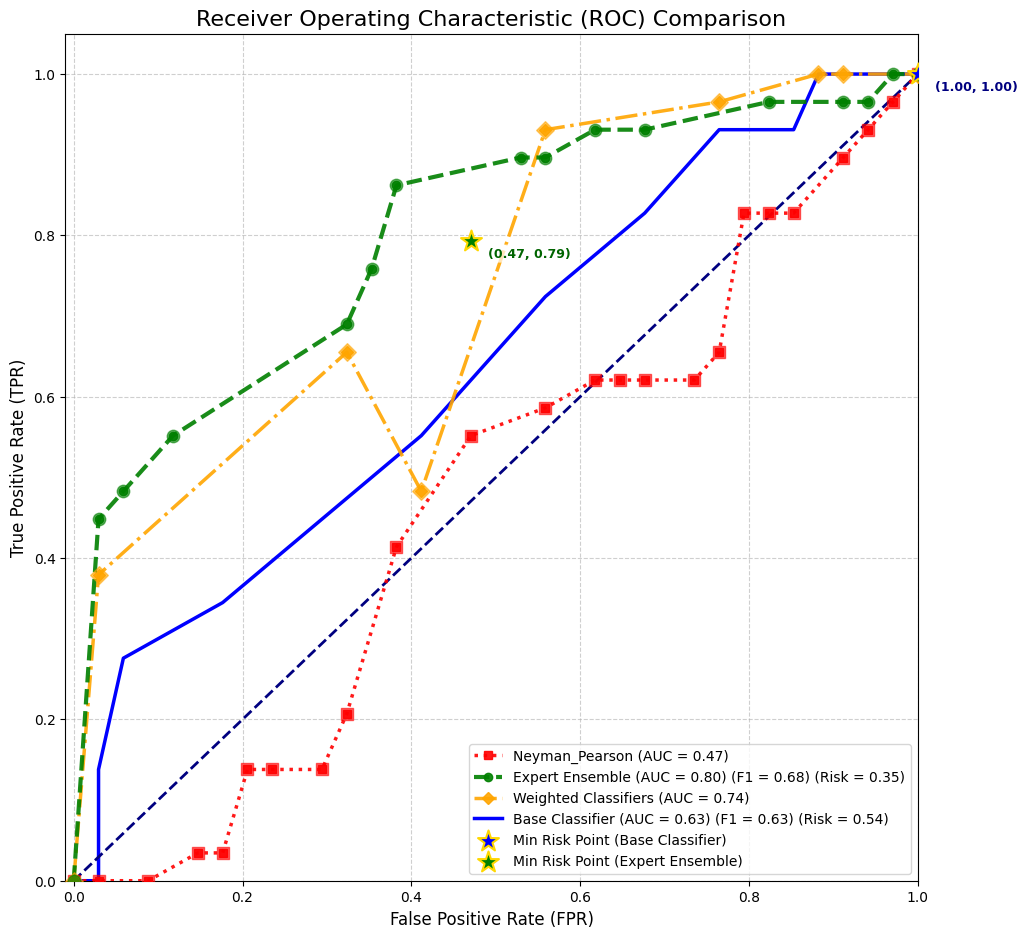

In [36]:

# plot the best classifiers of all folds
results_lists = []
#results_lists.extend(list_folds_best_models)
#results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(list_full_weighted_clfs)
#results_lists.append(misclassification_risk)

# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    #names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    names=["Neyman_Pearson", "Ensemble_voting_hard", "Weighted Classifiers"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_sonar", prior_prob=prior_proba, misclassification_risk=[misclassification_risk_orig, misclassification_risk_half_CV]
)


--- Plotting all ROC curves for comparison ---


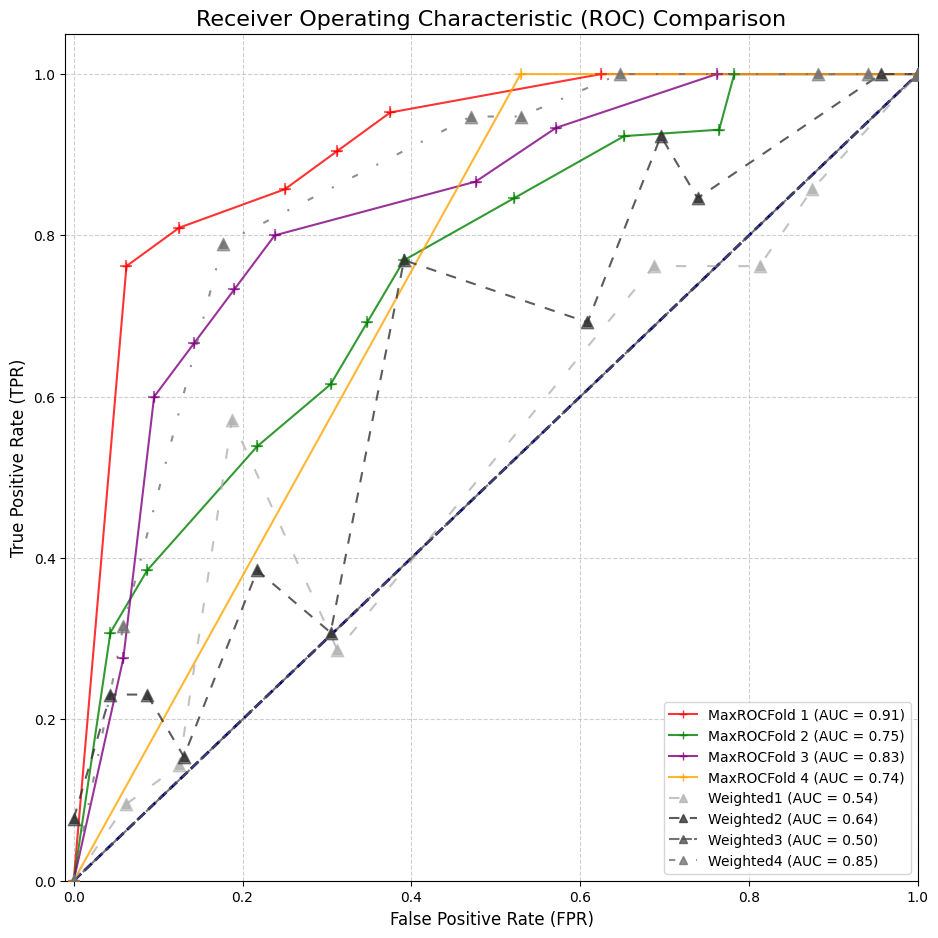

In [27]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
#results_lists.append(constrained_points)
#results_lists.append(ensemble_results_hard)
#results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    #names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_intermediate_sonar", prior_prob=prior_proba, misclassification_risk=None
)

## Bootstrap method

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.utils import resample

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# --- Bootstrapping Setup ---
n_samples = len(train_data_tensor)
original_indices = np.arange(n_samples)
n_iterations = 4
# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for ii in range(n_iterations):
    list_weighted_clfs = []  # List to store the models trained at each stage
    best_clfs = []           # List to store the best models from each stage
    best_model_paths = []    # List to store the path of the best model from each stage
    print(f"--- Starting Iteration {ii + 1}/{n_iterations} ---")

    # 1. Create bootstrap train and validation (out-of-bag) samples
    # Sample with replacement to get training indices
    train_ids = resample(original_indices, replace=True, n_samples=n_samples, random_state=ii)
    # Get out-of-bag (OOB) indices for validation
    # Note: Using np.unique(train_ids) is crucial because sampling with replacement creates duplicates.
    # setdiff1d finds elements in original_indices that are NOT in the unique set of train_ids.
    val_ids = np.setdiff1d(original_indices, np.unique(train_ids))

    # 2. Instantiate the LightningModule
    model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)

    # 3. Create datasets and dataloaders for the current iteration
    # Get the bootstrap training data by indexing the main tensor
    fold_train_features, fold_train_labels = train_data_tensor.tensors[0][train_ids], train_data_tensor.tensors[1][train_ids]
    fold_train_dataset = data.TensorDataset(fold_train_features, fold_train_labels)
    fold_train_loader = data.DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # Get the out-of-bag (OOB) validation data
    fold_val_features, fold_val_labels = train_data_tensor.tensors[0][val_ids], train_data_tensor.tensors[1][val_ids]
    fold_val_dataset = data.TensorDataset(fold_val_features, fold_val_labels)
    fold_loader = data.DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{ii+1}/',
            filename=f'best-model-fold{ii+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{ii+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=fold_train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {ii+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {ii+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {ii+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs.copy())
    list_folds_best_models.append(best_clfs.copy())




In [29]:
from predict_ensemble_and_evaluate_paper import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate_paper import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate_paper import plot_roc_comparison
from predict_ensemble_and_evaluate_paper import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_sonar_weighted_bootstrap.pkl')





Data saved to pickle/NN_sonar_weighted_bootstrap.pkl


{'best_models': [[{'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accuracy): BinaryAccuracy()
      (test_accuracy): BinaryAccuracy()
      (test_auc): BinaryAUROC()
    ),
    'fpr': np.float32(0.0),
    'tpr': np.float32(0.42857143),
    'threshold': np.float16(0.428)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accura

In [30]:
from predict_ensemble_and_evaluate_paper import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate_paper import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate_paper import plot_roc_comparison
from predict_ensemble_and_evaluate_paper import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_sonar_weighted_bootstrap.pkl')

Data loaded successfully.


In [31]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 46 models across all folds.
Extracting full dataset...
Getting predictions from all models...


In [32]:

misclassification_risk_half_bootstrap = results_tuple['misclassification_risk_half']


--- Plotting all ROC curves for comparison ---


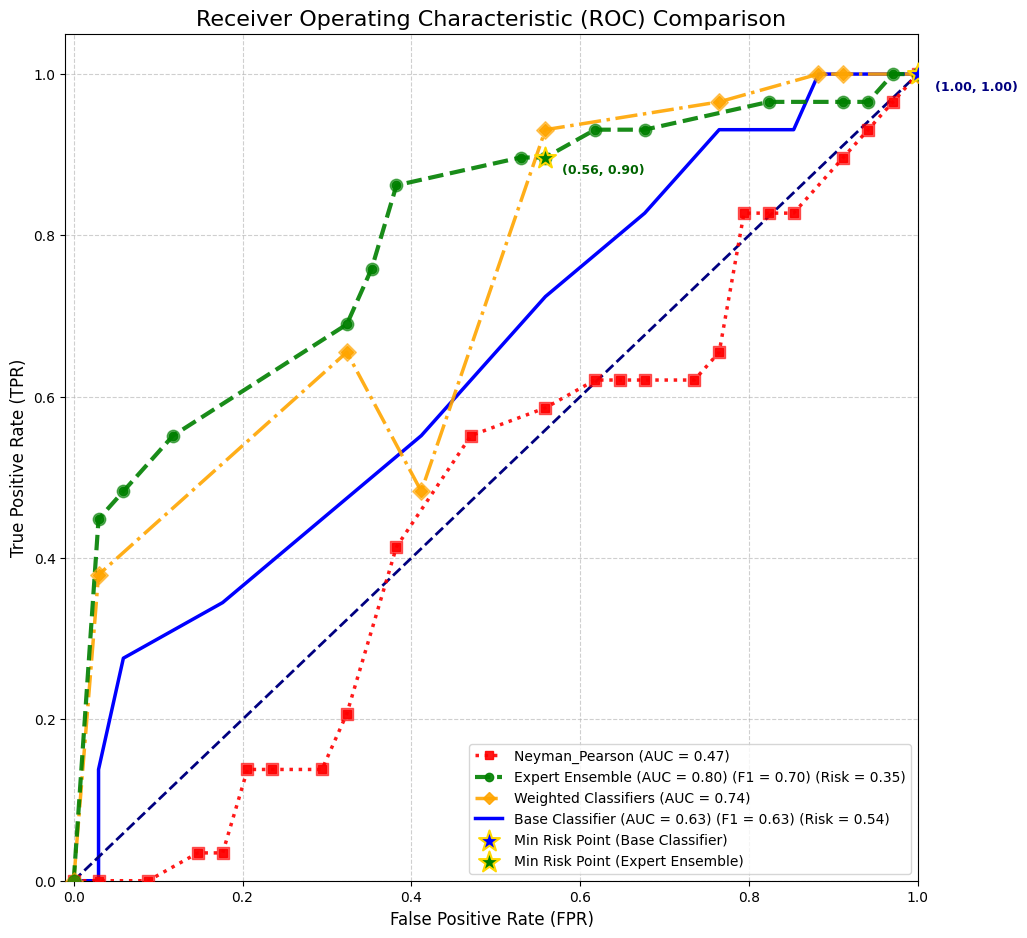

In [37]:

# plot the best classifiers of all folds
results_lists = []
#results_lists.extend(list_folds_best_models)
#results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(list_full_weighted_clfs)
#results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    #names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    names=["Neyman_Pearson", "Ensemble_voting_hard", "Weighted Classifiers"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_sonar_bootstrap", prior_prob=prior_proba, misclassification_risk=[misclassification_risk_orig, misclassification_risk_half_bootstrap]
)


--- Plotting all ROC curves for comparison ---


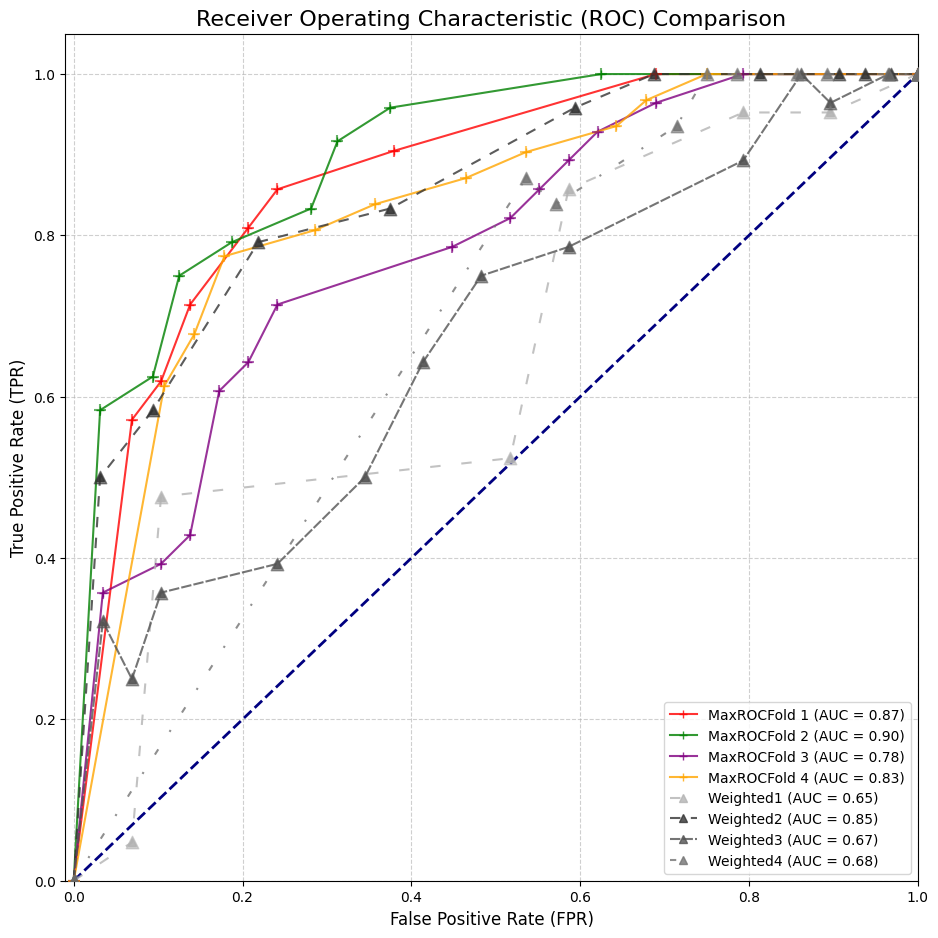

In [34]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
#results_lists.append(constrained_points)
#results_lists.append(ensemble_results_hard)
#results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    #names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_intermediate_sonar_bootstrap", prior_prob=prior_proba, misclassification_risk=None
)

### NOTES
* CV - Traiining data is large, stable, overlapping data partitions. Stable performance, good for estimating model accuracy.
* Bootstrap - More random samples with replacement. Diverse models, good for building an ensemble that generalizes well.


### Tabulate the misclassification risk

In [35]:

import termtables as tt

table_data = [
    ["Method", "Misclassification Risk", "F1", "FPR", "TPR"],
    ["Original Model", f"{misclassification_risk_orig['risk']:.4f}", f"{misclassification_risk_orig['f1']:.4f}", f"{misclassification_risk_orig['fpr']:.4f}", f"{misclassification_risk_orig['tpr']:.4f}"],
    ["Expert Ensemble (CV)", f"{misclassification_risk_half_CV['risk']:.4f}", f"{misclassification_risk_half_CV['f1']:.4f}", f"{misclassification_risk_half_CV['fpr']:.4f}", f"{misclassification_risk_half_CV['tpr']:.4f}"],
    ["Expert Ensemble (Bootstrap)", f"{misclassification_risk_half_bootstrap['risk']:.4f}", f"{misclassification_risk_half_bootstrap['f1']:.4f}", f"{misclassification_risk_half_bootstrap['fpr']:.4f}", f"{misclassification_risk_half_bootstrap['tpr']:.4f}"],
]

headers = table_data[0]
rows = table_data[1:]

print("\nMisclassification Risk Comparison NN sonar:")
print(tt.to_string(rows, header=headers, style=tt.styles.ascii_thin))


Misclassification Risk Comparison NN sonar:
+-----------------------------+------------------------+--------+--------+--------+
| Method                      | Misclassification Risk | F1     | FPR    | TPR    |
+-----------------------------+------------------------+--------+--------+--------+
| Original Model              | 0.5397                 | 0.6304 | 1.0000 | 1.0000 |
+-----------------------------+------------------------+--------+--------+--------+
| Expert Ensemble (CV)        | 0.3492                 | 0.6765 | 0.4706 | 0.7931 |
+-----------------------------+------------------------+--------+--------+--------+
| Expert Ensemble (Bootstrap) | 0.3492                 | 0.7027 | 0.5588 | 0.8966 |
+-----------------------------+------------------------+--------+--------+--------+
